# Data Preparation

In [1]:
claims <- read.csv(file="Claims.csv")
members <- read.csv(file="Members.csv")
drugs <- read.csv(file="DrugCount.csv")
labs <- read.csv(file="LabCount.csv")
dihY2 <- read.csv(file="DaysInHospital_Y2.csv")

## Data Selection

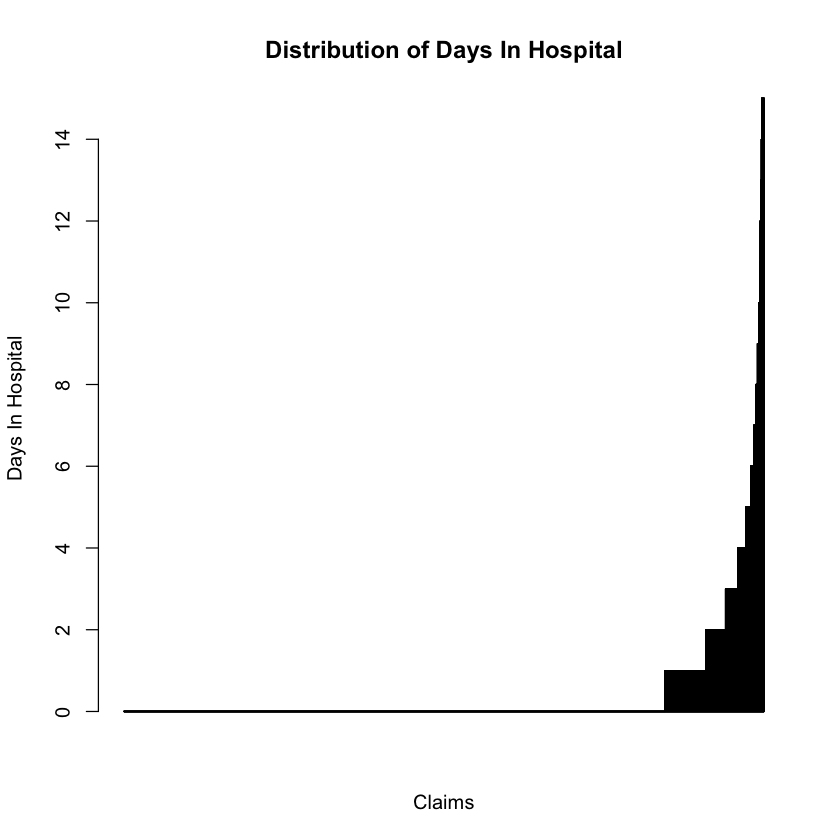

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   3.018   4.000  15.000 

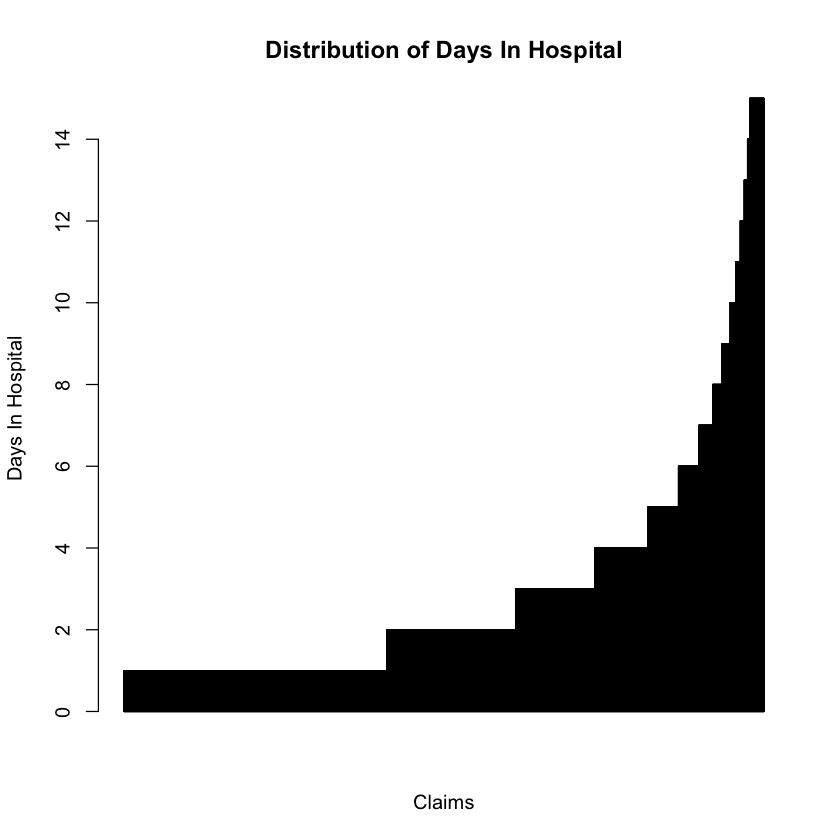

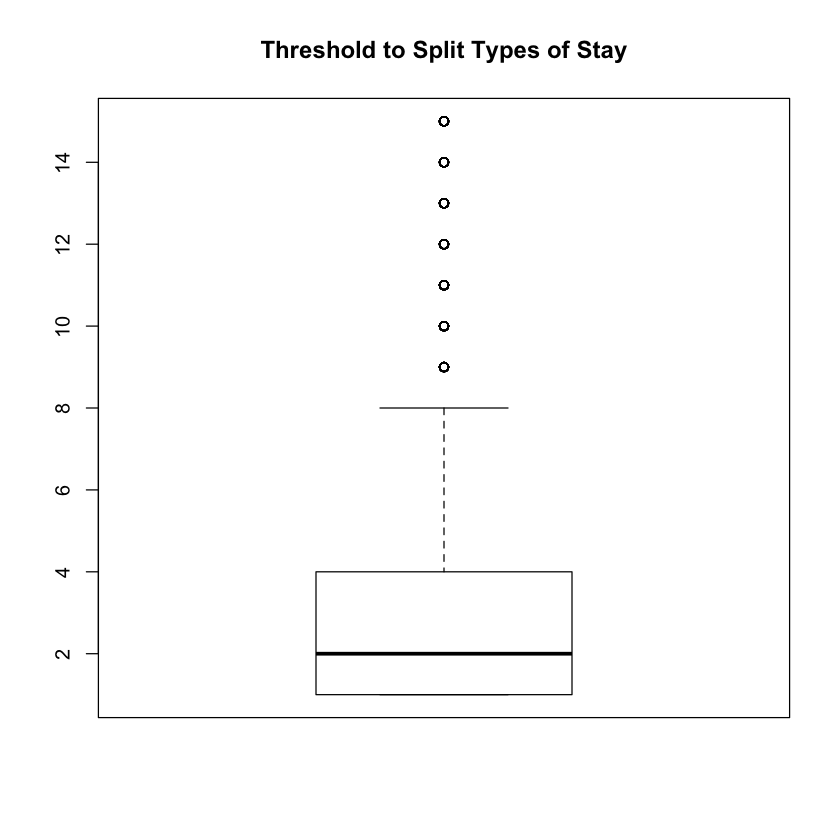

    MemberID                       PlaceSvc      LengthOfStay     
 Min.   :   20072   Office             :77988   Min.   : 0.00000  
 1st Qu.:23847874   Independent Lab    :39073   1st Qu.: 0.00000  
 Median :49250950   Urgent Care        :11343   Median : 0.00000  
 Mean   :49407960   Outpatient Hospital: 6551   Mean   : 0.06821  
 3rd Qu.:75026362   Inpatient Hospital : 6412   3rd Qu.: 0.00000  
 Max.   :99936299   Ambulance          : 1287   Max.   :42.00000  
                    (Other)            : 1440                     
 PrimaryConditionGroup CharlsonIndex    AgeAtFirstClaim   Sex       
 MSC2a3  :25809        Min.   :0.0000   Min.   : 0.00   F   :53236  
 METAB3  :18213        1st Qu.:0.0000   1st Qu.:60.00   M   :34773  
 ARTHSPIN:15346        Median :1.5000   Median :70.00   NA's:56085  
 NEUMENT : 9056        Mean   :0.9399   Mean   :63.83               
 MISCHRT : 7067        3rd Qu.:1.5000   3rd Qu.:80.00               
 GIBLEED : 6458        Max.   :5.0000   Max.   :80

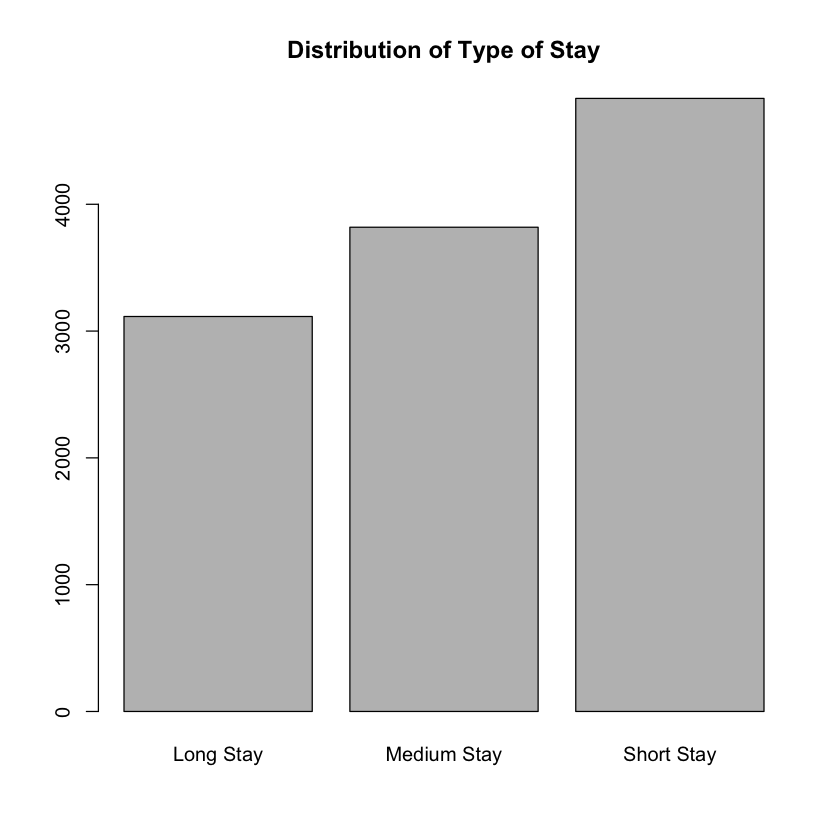

In [2]:
# if(!file.exists("all_clean.rds")) {
    # extract Y1
    claimsY1 <- claims[claims$Year == "Y1",]
    drugsY1 <- drugs[drugs$Year == "Y1",]
    labsY1 <- labs[labs$Year == "Y1",]
    membersY1 <- members
    
    # add number of claims
    n_claims <- table(claimsY1$MemberID)
    membersY1 <- merge(membersY1, data.frame(MemberID=names(n_claims),
      claims=as.numeric(n_claims)))
    
    # translate age WITH NA
    age <- gsub("(\\d+).*", "\\1", levels(membersY1$AgeAtFirstClaim))
    levels(membersY1$AgeAtFirstClaim) <- age
    membersY1$AgeAtFirstClaim <- as.numeric(as.character(membersY1$AgeAtFirstClaim))
    
    # DaysInHospital
    membersY1 <- merge(membersY1, dihY2)
    barplot(sort(membersY1$DaysInHospital), ylab="Days In Hospital",xlab="Claims", main="Distribution of Days In Hospital")
    membersY1 <- membersY1[membersY1$DaysInHospital>0,]
    barplot(sort(membersY1$DaysInHospital), ylab="Days In Hospital",xlab="Claims", main="Distribution of Days In Hospital")
    summary(membersY1$DaysInHospital)
    boxplot(membersY1$DaysInHospital, main="Threshold to Split Types of Stay")
    membersY1$InHospital[membersY1$DaysInHospital==1] <- "Short Stay"
    membersY1$InHospital[membersY1$DaysInHospital<=3&membersY1$DaysInHospital>=2] <- "Medium Stay"
    membersY1$InHospital[membersY1$DaysInHospital>3] <- "Long Stay"
    membersY1$InHospital <- as.factor(membersY1$InHospital)
    membersY1 <- subset(membersY1, select=c(MemberID, AgeAtFirstClaim, Sex, claims, InHospital))
    barplot(table(membersY1$InHospital), main="Distribution of Type of Stay")
#     summary(membersY1) # shows class inbalanced problem
    

    #Gender WITH NA
    membersY1$Sex[membersY1$Sex == ""] <- NA
    membersY1$Sex <- factor(membersY1$Sex)
    
    #DRUG CLAIM
    n_dclaims <- table(drugsY1$MemberID)
    membersY1 <- merge(membersY1, data.frame(MemberID=names(n_dclaims),
      dclaims=as.numeric(n_dclaims)))   


    #DRUG
    levels(drugsY1$DrugCount) <- c(1,2,3,4,5,6,7)
    drugsY1$DrugCount <- as.numeric(as.character(drugsY1$DrugCount))
    drugsY1$MemberID <- as.factor(drugsY1$MemberID)
    drugsY1 <- aggregate(DrugCount~MemberID, drugsY1, sum)
    membersY1 <- merge(membersY1,data.frame(MemberID = drugsY1$MemberID,DrugCount = as.numeric(drugsY1$DrugCount)))
    # summary(membersY1)

    #LAB
    levels(labsY1$LabCount) <- c(1,10,2,3,4,5,6,7,8,9)
    labsY1$LabCount <- as.numeric(as.character(labsY1$LabCount))
    labsY1$MemberID <- as.factor(labsY1$MemberID)
    labsY1 <- aggregate(LabCount~MemberID, labsY1, sum)
    membersY1 <- merge(membersY1,data.frame(MemberID = labsY1$MemberID,LabCount = as.numeric(labsY1$LabCount)))
    
    # translate Charlson Index
    levels(claimsY1$CharlsonIndex) <- c(0, 1.5, 3.5, 5)
    claimsY1$CharlsonIndex <- as.numeric(as.character(claimsY1$CharlsonIndex))

    #translate LOS
    levels(claimsY1$LengthOfStay) <- c(0, 1, 11, 2, 21, 112, 3, 4, 42, 5, 6)
    claimsY1$LengthOfStay <- as.numeric(as.character(claimsY1$LengthOfStay))
    
    claimsY1 <- data.frame(MemberID = claimsY1$MemberID, 
                           PlaceSvc = claimsY1$PlaceSvc,
                           LengthOfStay = claimsY1$LengthOfStay,
                           PrimaryConditionGroup = claimsY1$PrimaryConditionGroup, 
                           CharlsonIndex = claimsY1$CharlsonIndex)
    claimsY1 <- claimsY1[claimsY1$PrimaryConditionGroup!="",]
    claimsY1$PrimaryConditionGroup <- factor(claimsY1$PrimaryConditionGroup)
    claimsY1 <- claimsY1[claimsY1$PlaceSvc!="",]
    claimsY1$PlaceSvc <- factor(claimsY1$PlaceSvc)
#     summary(claimsY1)
#     summary(membersY1)
    allset <- merge(claimsY1, membersY1, by = "MemberID")
#     summary(allset)
    save(allset, file="all_clean.rds")
# }

load("all_clean.rds")
summary(allset)

1. Eliminate missing rows in PlaceSvc, PrimaryConditionGroup; Impute zero to missing rows in LOS
2. Age and Sex contain NAs, depends on model we use.
3. InHospital shows class inbalanced problem solved by stay type selection (Barplot details)
4. Ignore truncatedClaim column (check discussion reply)

## Dummy and Scaling

In [3]:
library(lattice)
library(ggplot2)
library(caret)
nodummy <- subset(allset, select=c(MemberID, InHospital))
yesdummy <- allset[ , ! colnames(allset) %in% c("InHospital") ]
data_dummy <- predict(dummyVars(~., yesdummy), yesdummy)
data_dummy <- data.frame(data_dummy)
summary(data_dummy)
dummy_only <- data_dummy

    MemberID        PlaceSvc.Ambulance PlaceSvc.Home     
 Min.   :   20072   Min.   :0.000000   Min.   :0.000000  
 1st Qu.:23847874   1st Qu.:0.000000   1st Qu.:0.000000  
 Median :49250950   Median :0.000000   Median :0.000000  
 Mean   :49407960   Mean   :0.008932   Mean   :0.002394  
 3rd Qu.:75026362   3rd Qu.:0.000000   3rd Qu.:0.000000  
 Max.   :99936299   Max.   :1.000000   Max.   :1.000000  
                                                         
 PlaceSvc.Independent.Lab PlaceSvc.Inpatient.Hospital PlaceSvc.Office 
 Min.   :0.0000           Min.   :0.0000              Min.   :0.0000  
 1st Qu.:0.0000           1st Qu.:0.0000              1st Qu.:0.0000  
 Median :0.0000           Median :0.0000              Median :1.0000  
 Mean   :0.2712           Mean   :0.0445              Mean   :0.5412  
 3rd Qu.:1.0000           3rd Qu.:0.0000              3rd Qu.:1.0000  
 Max.   :1.0000           Max.   :1.0000              Max.   :1.0000  
                                       

In [4]:
weight <- matrix(c(rep(1/8,8),1,rep(1/45,45),1,1,1/2,1/2,1,1,1,1), 
   ncol = 62, 
   nrow = nrow(data_dummy), 
   byrow = TRUE)
temp <- scale(data_dummy[, -c(1)])*weight
data_dummy[, -c(1)] <- temp
scaled <- data_dummy

In [5]:
# Problem: number of row will increase if merge
dummy_only$InHospital <- nodummy$InHospital
dummy_only <- dummy_only[ , ! colnames(dummy_only) %in% c("MemberID") ]
scaled$InHospital <- nodummy$InHospital
scaled <- scaled[ , ! colnames(scaled) %in% c("MemberID") ]

In [6]:
scaled_nona <- na.omit(scaled)

Scaled data is for models which need to compute Euclidian distance(KNN), otherwise, just need Dummy only data(Dtree).

## Outlier Removal

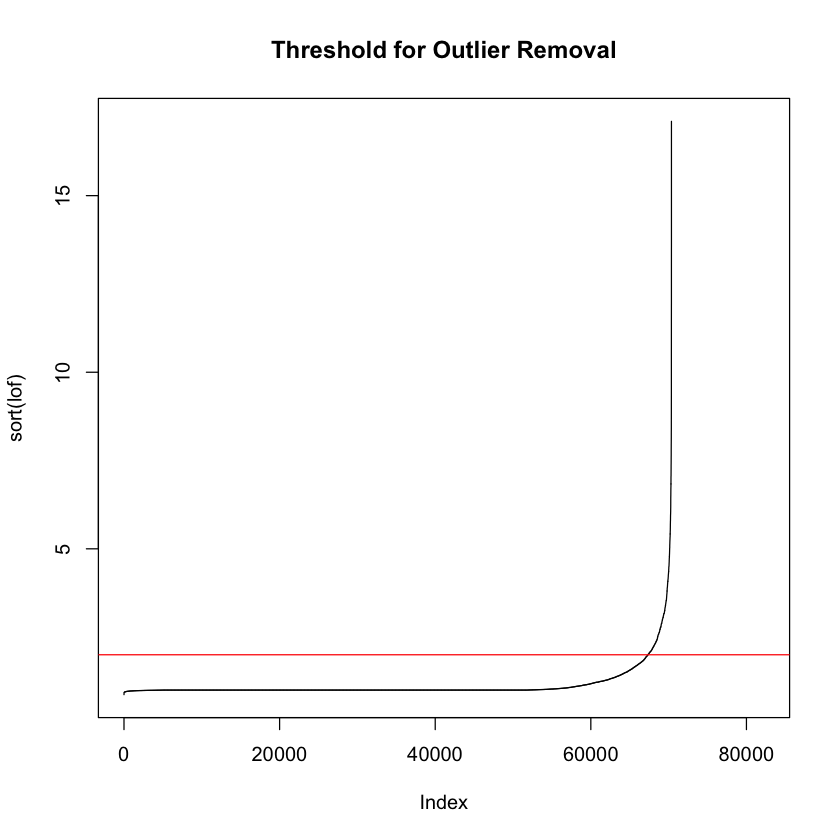

In [7]:
# install.packages("dbscan")
library(dbscan)
lof <- lof(scaled_nona[2:ncol(scaled_nona)-1], k = 3)
plot(sort(lof), type = "l", main="Threshold for Outlier Removal")
abline(h = 2, col = "red")

In [8]:
# summary(scaled_nona[2:ncol(scaled_nona)-1])
# summary(scaled_nona[lof <=2,])
# summary(scaled_nona[lof >2,])
scaled_nona <- scaled_nona[lof <= 2,]


Before removing outliers, it needs to eliminate NA first. Also, removing outliers is to prepare for models other than Dtree, which need to eliminate NA as well. Because Dtree is robust to outliers and NA, plus, outliers are just few(5%) of total dataset, which means we can leave it there for Dtree.

Although we find this statment by research, we will prove it by same method and two datasets later.

## Feature Selection

In [9]:
library(FSelector)
importance <- chi.squared(InHospital ~ ., data=scaled_nona)
importance

,attr_importance
PlaceSvc.Ambulance,0.00000000
PlaceSvc.Home,0.00000000
PlaceSvc.Independent.Lab,0.03160257
PlaceSvc.Inpatient.Hospital,0.03496575
PlaceSvc.Office,0.00000000
PlaceSvc.Other,0.00000000
PlaceSvc.Outpatient.Hospital,0.00000000
PlaceSvc.Urgent.Care,0.00000000
LengthOfStay,0.00000000
PrimaryConditionGroup.AMI,0.04576779


In [10]:
str(importance)
o <- order(importance$attr_importance)
# dotchart(importance$attr_importance[o], labels = rownames(importance)[o],
#   xlab = "Importance")
# importance <- data.frame(name = rownames(importance),value = importance$attr_importance)
# importance

'data.frame':	62 obs. of  1 variable:
 $ attr_importance: num  0 0 0.0316 0.035 0 ...


,name,value
56,PrimaryConditionGroup.PRGNCY,0.06578272
57,CharlsonIndex,0.07919507
58,dclaims,0.08940017
59,AgeAtFirstClaim,0.11231226
60,LabCount,0.14279831
61,claims,0.15114414
62,DrugCount,0.18523062


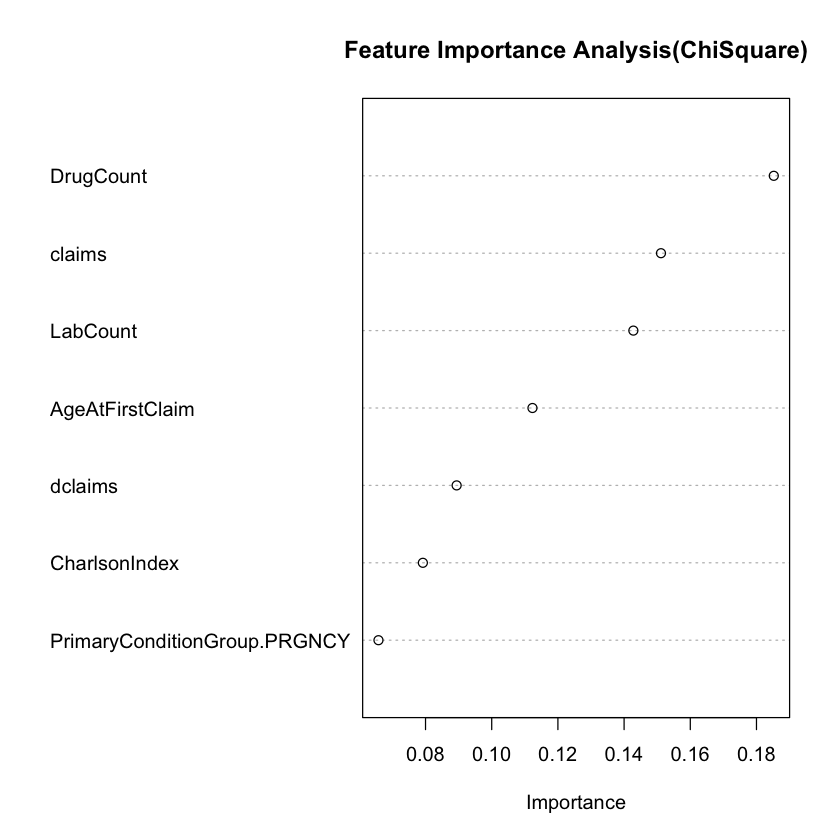

In [11]:
im <- data.frame(name = rownames(importance)[o], value = importance$attr_importance[o])
im <- im[im$value>0.06,]
im
dotchart(im$value, labels = im$name,
  xlab = "Importance", main="Feature Importance Analysis(ChiSquare)")

In [12]:
# could find a better way to code this
# dummy_only_important <- subset(dummy_only, select = c(PrimaryConditionGroup.COPD,
#                                                        PrimaryConditionGroup.INFEC4,
#                                                        PrimaryConditionGroup.MSC2a3,
#                                                        PrimaryConditionGroup.RESPR4,
#                                                        PrimaryConditionGroup.CANCRB,
#                                                        Sex.F,
#                                                        Sex.M,
#                                                        PlaceSvc.Independent.Lab,
#                                                        PrimaryConditionGroup.FXDISLC,
#                                                        PrimaryConditionGroup.NEUMENT,
#                                                        PlaceSvc.Inpatient.Hospital,
#                                                        PrimaryConditionGroup.HEMTOL,
#                                                        PrimaryConditionGroup.HEART2,
#                                                        PrimaryConditionGroup.AMI,
#                                                        PrimaryConditionGroup.PRGNCY,
#                                                        CharlsonIndex,
#                                                        dclaims,
#                                                        AgeAtFirstClaim,
#                                                        LabCount,
#                                                        claims,
#                                                        DrugCount))
# dummy_only_important$InHospital <- dummy_only$InHospital
# scaled_nona_important <- subset(scaled_nona, select =c(PrimaryConditionGroup.COPD,
#                                                        PrimaryConditionGroup.INFEC4,
#                                                        PrimaryConditionGroup.MSC2a3,
#                                                        PrimaryConditionGroup.RESPR4,
#                                                        PrimaryConditionGroup.CANCRB,
#                                                        Sex.F,
#                                                        Sex.M,
#                                                        PlaceSvc.Independent.Lab,
#                                                        PrimaryConditionGroup.FXDISLC,
#                                                        PrimaryConditionGroup.NEUMENT,
#                                                        PlaceSvc.Inpatient.Hospital,
#                                                        PrimaryConditionGroup.HEMTOL,
#                                                        PrimaryConditionGroup.HEART2,
#                                                        PrimaryConditionGroup.AMI,
#                                                        PrimaryConditionGroup.PRGNCY,
#                                                        CharlsonIndex,
#                                                        dclaims,
#                                                        AgeAtFirstClaim,
#                                                        LabCount,
#                                                        claims,
#                                                        DrugCount))
dummy_only_important <- subset(dummy_only, select = c( PrimaryConditionGroup.PRGNCY,
                                                       CharlsonIndex,
                                                       dclaims,
                                                       AgeAtFirstClaim,
                                                       LabCount,
                                                       claims,
                                                       DrugCount))
dummy_only_important$InHospital <- dummy_only$InHospital
scaled_nona_important <- subset(scaled_nona, select =c(PrimaryConditionGroup.PRGNCY,
                                                       CharlsonIndex,
                                                       dclaims,
                                                       AgeAtFirstClaim,
                                                       LabCount,
                                                       claims,
                                                       DrugCount))
scaled_nona_important$InHospital <- scaled_nona$InHospital
# summary(scaled_nona_important)
finalscaled <- scaled_nona_important
finaldummy <- dummy_only_important

Select those attributes are important to our target, because most of them are zero and the maximum of the rests is .19, then just keep those non-zero attributes.

# Modeling

## Try to find some clue before modeling(extra work)

In [13]:
# library(scatterplot3d)
# top3 <- subset(finalscaled, select = c(DrugCount, claims, LabCount,InHospital))
# top3$color[top3$InHospital=="Short Stay"] <- "red"
# top3$color[top3$InHospital=="Medium Stay"] <- "blue"
# top3$color[top3$InHospital=="Long Stay"] <- "green"
# plot(x=top3$DrugCount,xlab="DrugCount",y=top3$claims,ylab="claims",col=top3$color)
# # summary(top3)
# scatterplot3d(x=top3$DrugCount,xlab="DrugCount",y=top3$claims,ylab="claims",z=top3$LabCount,zlab="LabCount",color=top3$color)
# legend("topleft", inset=.05,      # location and inset
#     bty="n", cex=.8,              # suppress legend box, shrink text 50%
#     title="Stay Type",
#     c("Short Stay", "Medium Stay", "Long Stay"), fill=c("red", "blue", "darkgreen"))


Try to find some clue by plot those top 3 important attributes and colored by stay type, but...

## Prepare For Validation
### Holdout Sample-Dummy only

In [14]:
n_train <- as.integer(nrow(finaldummy)*.66)
# n_train
train_id <- sample(1:nrow(finaldummy), n_train)
# head(train_id)
train <- finaldummy[train_id,]
test <- finaldummy[-train_id, colnames(finaldummy) != "InHospital"]
test_type <- finaldummy[-train_id, "InHospital"]

### Holdout Sample-Clean Scaled

In [15]:
n_train <- as.integer(nrow(finalscaled)*.66)
# n_train
train_id <- sample(1:nrow(finalscaled), n_train)
# head(train_id)
train <- finalscaled[train_id,]
test <- finalscaled[-train_id, colnames(finalscaled) != "InHospital"]
test_type <- finalscaled[-train_id, "InHospital"]

### 10-Fold Cross Validation-Dummy Only

In [16]:
index <- 1:nrow(finaldummy)
index <- sample(index) ### shuffle index
fold <- rep(1:10, each=nrow(finaldummy)/10)[1:nrow(finaldummy)]

folds <- split(index, fold) ### create list with indices for each fold

### 10-Fold Cross Validation-Clean Scaled

In [17]:
index <- 1:nrow(finalscaled)
index <- sample(index) ### shuffle index
fold <- rep(1:10, each=nrow(finalscaled)/10)[1:nrow(finalscaled)]

folds <- split(index, fold) ### create list with indices for each fold

### Accuracy Function

In [18]:
accuracy <- function(truth, prediction) {
    tbl <- table(truth, prediction)
    sum(diag(tbl))/sum(tbl)
}

## Decision Tree-CART-Holdout(using dummy only, contains outliers and NAs)

In [19]:
library(rpart)
model <- rpart(InHospital ~ ., data=train, control=rpart.control(cp=0.005))
model

n= 44458 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

  1) root 44458 29295 Short Stay (0.3398488 0.3190877 0.3410635)  
    2) LabCount>=-0.282604 25265 15571 Long Stay (0.3836929 0.3337819 0.2825252)  
      4) claims>=1.273277 3702  1808 Long Stay (0.5116153 0.2533766 0.2350081) *
      5) claims< 1.273277 21563 13763 Long Stay (0.3617307 0.3475861 0.2906831)  
       10) AgeAtFirstClaim< -1.635109 1573   765 Medium Stay (0.3210426 0.5136682 0.1652893) *
       11) AgeAtFirstClaim>=-1.635109 19990 12695 Long Stay (0.3649325 0.3345173 0.3005503)  
         22) claims>=-0.9949935 18562 11684 Long Stay (0.3705420 0.3433897 0.2860683)  
           44) LabCount< 3.519929 18359 11549 Long Stay (0.3709352 0.3471867 0.2818781)  
             88) LabCount< -0.1739602 1532   820 Long Stay (0.4647520 0.2343342 0.3009138) *
             89) LabCount>=-0.1739602 16827 10729 Long Stay (0.3623938 0.3574612 0.2801450)  
              178) DrugCount>=0.2063936 8560  5089 Lon

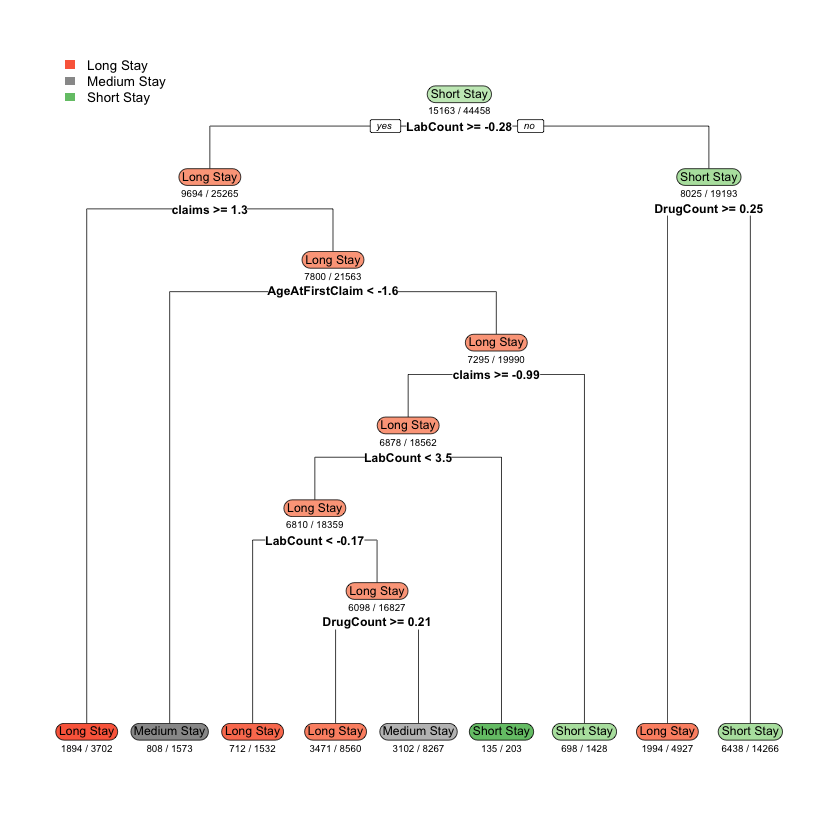

In [20]:
library(rpart.plot)
rpart.plot(model, extra = 2, under = TRUE, varlen=0, faclen=0)

In [21]:
accuracy(train$InHospital, predict(model, train, type="class"))
accuracy(test_type, predict(model, test, type="class"))

[1] 0.4330379

[1] 0.4400734

## Decision Tree-CART-10-fold-CV(using dummy only, contains outliers and NAs)

In [22]:
accs <- vector(mode="numeric")
for(i in 1:length(folds)) {
    model <- rpart(InHospital ~., data=finaldummy[-folds[[i]],], control=rpart.control(cp=0.003))
    accs[i] <- accuracy(finaldummy[folds[[i]],]$InHospital, predict(model, finaldummy[folds[[i]],], type="class"))
}
accs

[1] 0.4159739 0.4085511 0.4101841 0.3883610 0.3885095 0.4141924 0.4039489
 [8] 0.3953385 0.4069181 0.4008314

In [23]:
mean(accs)

[1] 0.4032809

## Decision Tree-CART-10-fold-CV(using Clean Scaled)

In [24]:
accs <- vector(mode="numeric")
for(i in 1:length(folds)) {
    model <- rpart(InHospital ~., data=finalscaled[-folds[[i]],], control=rpart.control(cp=0.003))
    accs[i] <- accuracy(finalscaled[folds[[i]],]$InHospital, predict(model, finalscaled[folds[[i]],], type="class"))
}
accs

[1] 0.4713480 0.4714964 0.4569477 0.4682304 0.4348278 0.4437352 0.4553147
 [8] 0.4340855 0.4720903 0.4403207

In [25]:
mean(accs)

[1] 0.4548397

It shows cleaned and scaled data performing a better result than the data with outliers and NA.

## Decision Tree-CART-caret_10foldCV(using Clean Scaled)
Can't contain NA value, then use clean scaled data.

In [26]:
library(caret)
library(e1071)
fit <- train(InHospital ~ ., data = finalscaled , method = "rpart",
    control=rpart.control(cp=0.003),
    trControl = trainControl(method = "cv", number = 10),
    tuneLength=5)
fit

CART 

67361 samples
    7 predictor
    3 classes: 'Long Stay', 'Medium Stay', 'Short Stay' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 60625, 60624, 60625, 60625, 60625, 60625, ... 
Resampling results across tuning parameters:

  cp           Accuracy   Kappa     
  0.003236539  0.4427785  0.16054387
  0.003983433  0.4378500  0.15343394
  0.004956658  0.4354302  0.14941045
  0.013806215  0.4045963  0.09535200
  0.086730190  0.3647210  0.03258992

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.003236539.

## Decision Tree-CART-caret_bootstrap(using Clean Scaled)

In [27]:
library(caret)
library(e1071)
fit <- train(InHospital ~ ., data = finalscaled , method = "rpart",
    control=rpart.control(cp=0.003),
    trControl = trainControl(method = "boot", number = 10),
    tuneLength=5)
fit

CART 

67361 samples
    7 predictor
    3 classes: 'Long Stay', 'Medium Stay', 'Short Stay' 

No pre-processing
Resampling: Bootstrapped (10 reps) 
Summary of sample sizes: 67361, 67361, 67361, 67361, 67361, 67361, ... 
Resampling results across tuning parameters:

  cp           Accuracy   Kappa     
  0.003236539  0.4459418  0.16386349
  0.003983433  0.4367692  0.14991586
  0.004956658  0.4281242  0.13577858
  0.013806215  0.4010339  0.08993175
  0.086730190  0.3667985  0.03586215

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.003236539.

## Naive Bayes-Holdout(using clean scaled)

Loading required package: MASS


[1] 0.4050565

[1] 0.4126534

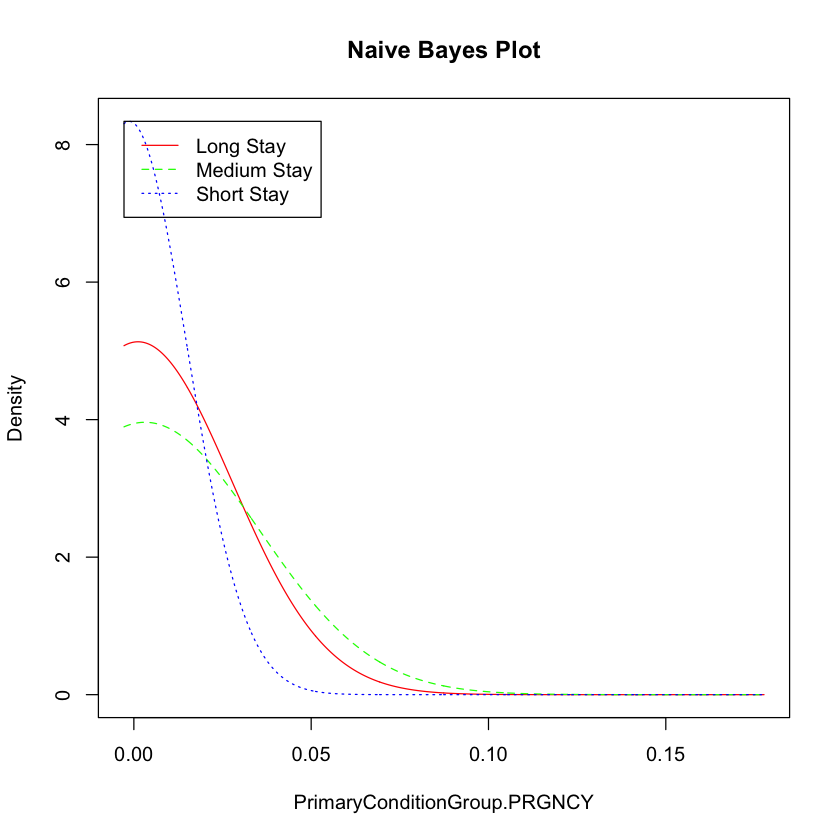

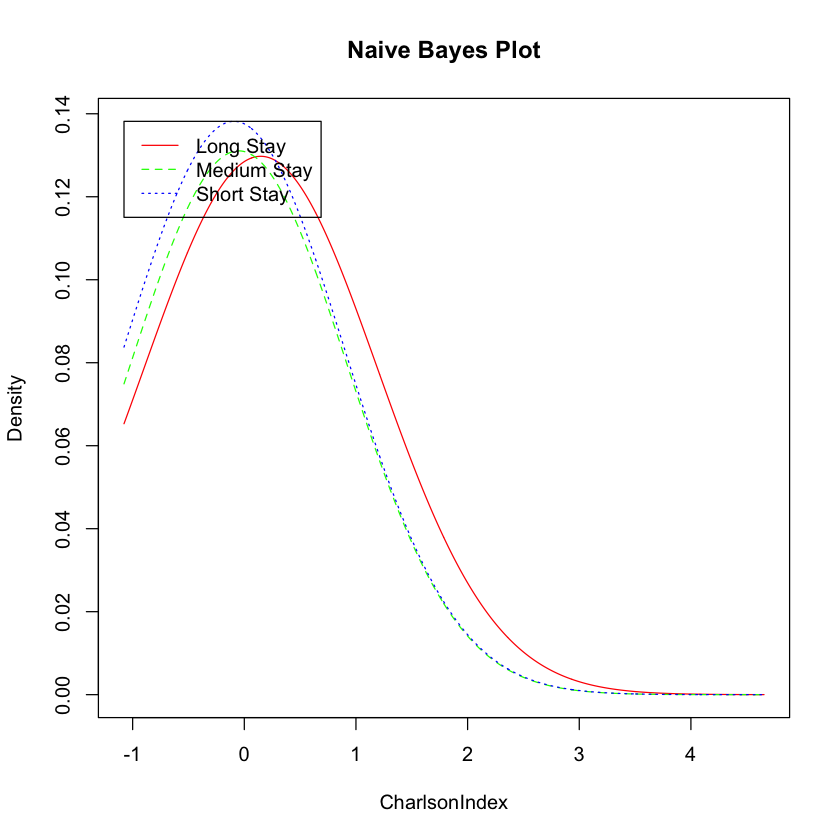

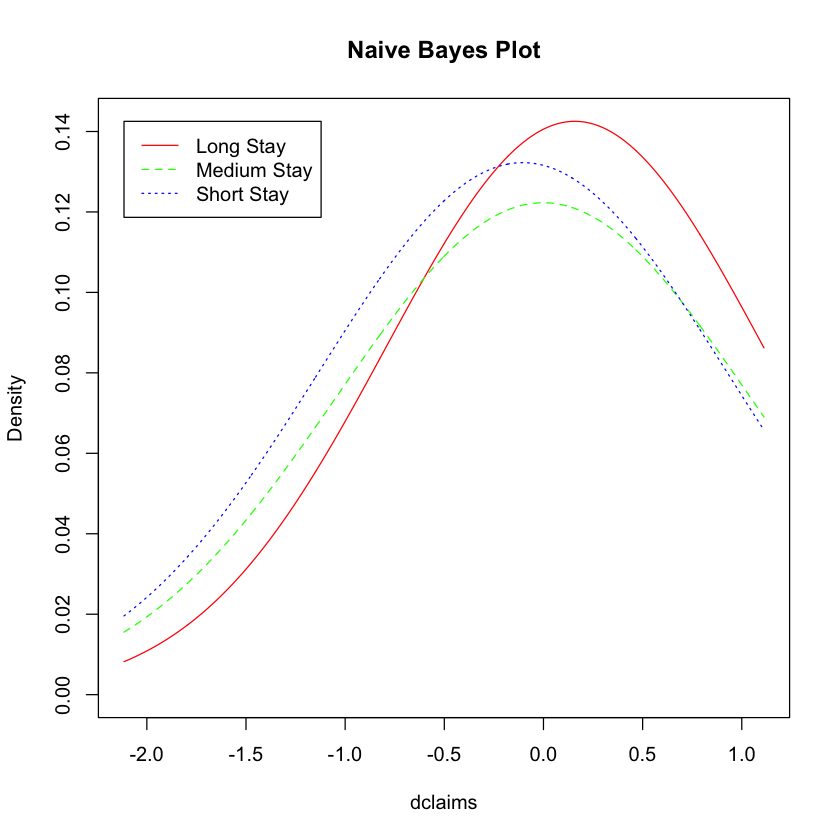

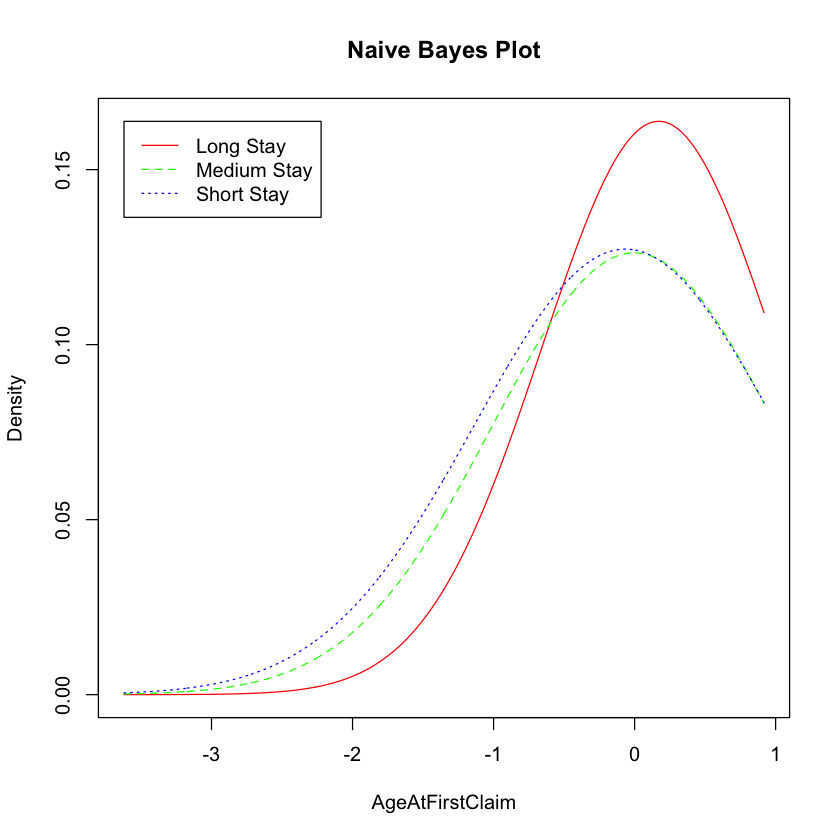

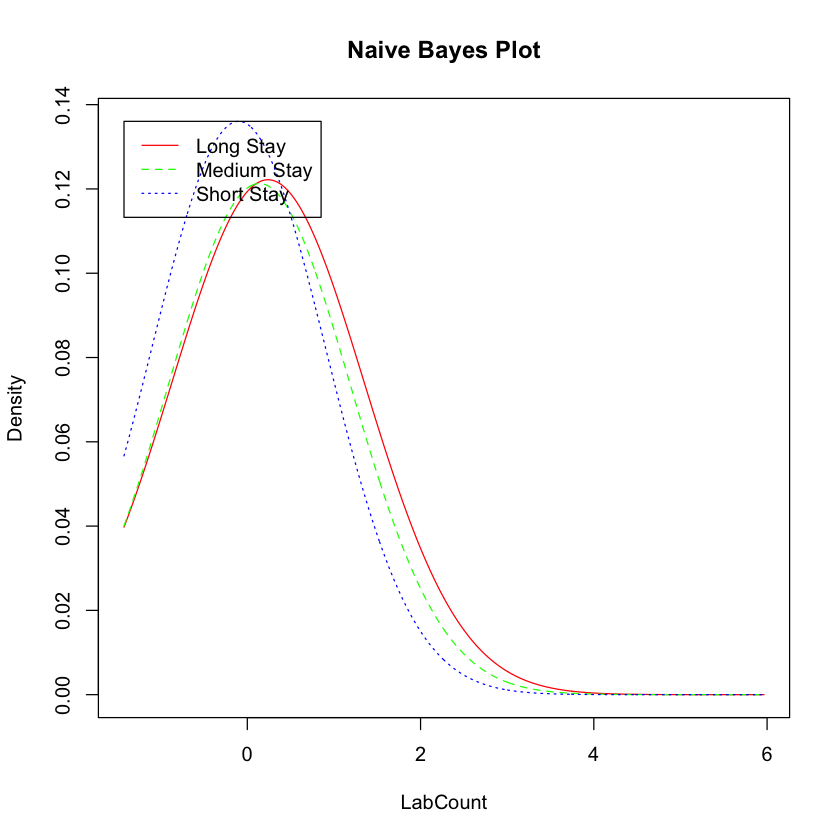

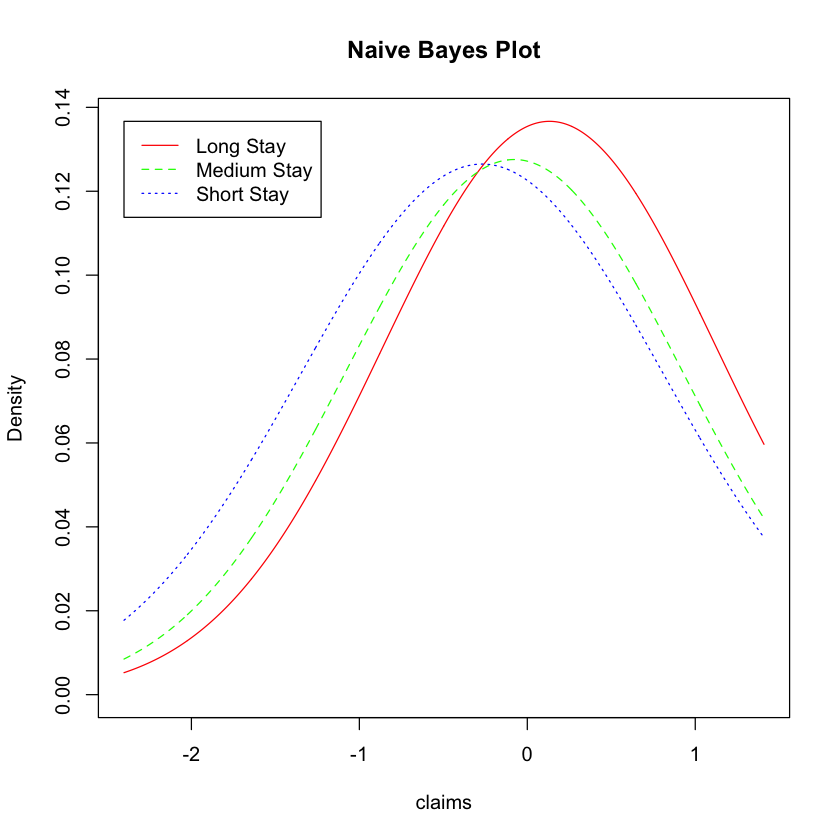

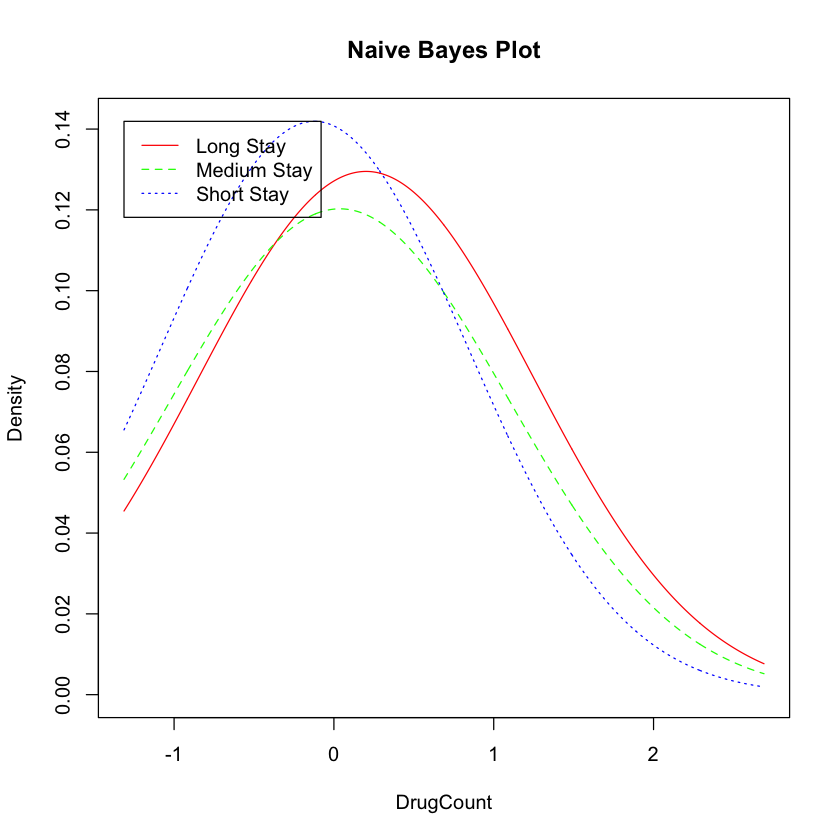

In [28]:
library(klaR)
library(MASS)
options(warn=-1)
nbmodel <- NaiveBayes(InHospital ~ ., data=train)
accuracy(train$InHospital, predict(nbmodel, train, type="class")$class)
accuracy(test_type, predict(nbmodel, test, type="class")$class)
options(warn=0)
plot(nbmodel)

## SVM-Radial-Holdout(using clean scaled) (run and do something else, need 10+ mins to finish)

In [29]:
svmmodel <- svm(InHospital ~ ., data=train, kernel = "radial")
accuracy(train$InHospital, predict(svmmodel, train, type="class"))
accuracy(test_type, predict(svmmodel, test, type="class"))

[1] 0.4792163

[1] 0.4781906

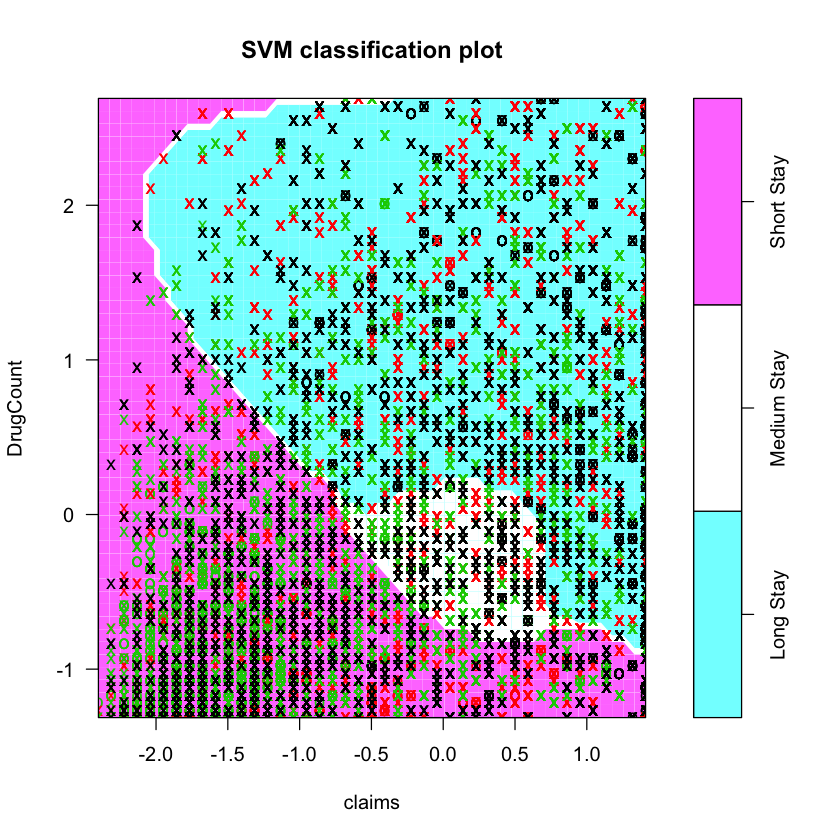

In [63]:
# summary(train)
plot(svmmodel,train,DrugCount~claims)

# Modeling using "caret" *3, try "cv", "boot"

## caret-rpart-10fold

In [32]:
library(caret)
library(e1071)
fit <- train(InHospital ~ ., data = finalscaled , method = "rpart",
    control=rpart.control(cp=0.003),
    trControl = trainControl(method = "cv", number = 10),
    tuneLength=5)
fit

CART 

67361 samples
    7 predictor
    3 classes: 'Long Stay', 'Medium Stay', 'Short Stay' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 60626, 60625, 60624, 60625, 60625, 60626, ... 
Resampling results across tuning parameters:

  cp           Accuracy   Kappa     
  0.003236539  0.4374192  0.15284463
  0.003983433  0.4357268  0.15022717
  0.004956658  0.4333367  0.14631263
  0.013806215  0.4038534  0.09577077
  0.086730190  0.3645279  0.03230844

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was cp = 0.003236539.

## Complexity-Accuracy plot

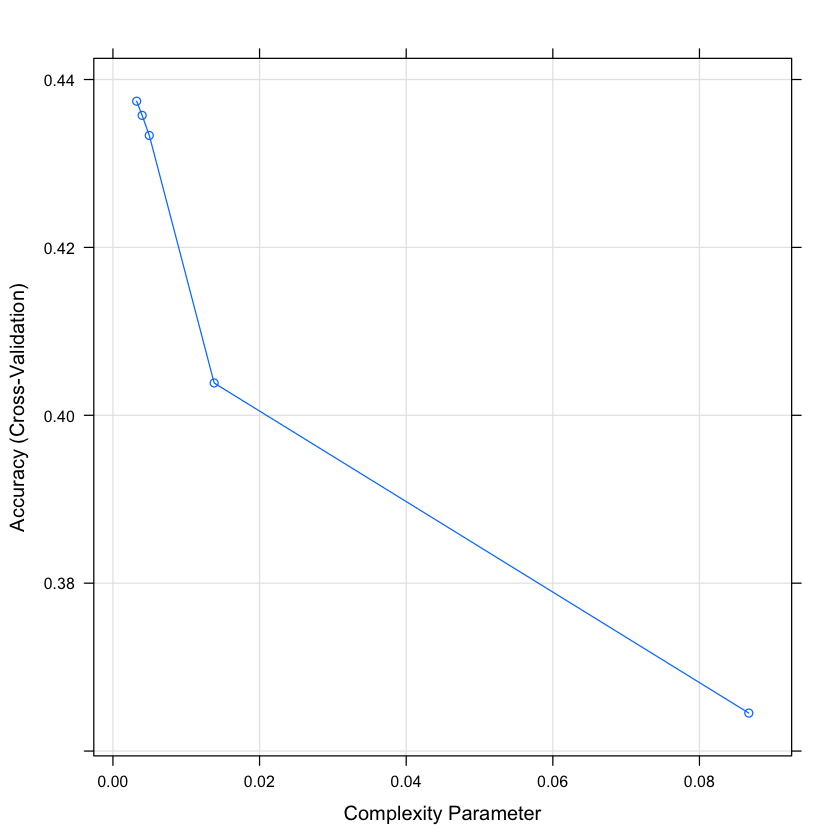

In [33]:
plot(fit)

## caret-svm_radial-10fold(run and do something else, need 10+ mins to finish)

In [34]:
# nrow(train)

In [35]:

# train <- createFolds(finalscaled$InHospital, k=10)
# svmFit <- train(InHospital ~., method = "lssvmRadial", data = finalscaled,
#     tuneLength = 5,
#     trControl = trainControl(
#         method = "cv", indexOut = train))
# svmFit

## caret-knn-10fold

In [36]:
# train <- createFolds(finalscaled$InHospital, k=10)
# knnFit <- train(InHospital ~ ., method = "knn", data = finalscaled,
#     tuneLength = 5,  tuneGrid=data.frame(k=1:10),
#     trControl = trainControl(
#         method = "cv", indexOut = train))
# knnFit

# Compare Models from "caret-method" and from "package named by model"(extra work)

## Package "caret-knn3"

In [37]:
# model <- knn3(InHospital ~ ., data=finalscaled, k = 3)
# accs <- vector(mode="numeric")
# for(i in 1:length(folds)) {
#     model <- knn3(InHospital ~ ., data=finalscaled[-folds[[i]],], k = 3)
#     accs[i] <- accuracy(finalscaled[folds[[i]],]$type, predict(model, finalscaled[folds[[i]],], type="class"))
# }
# accs

# Model Comparison

## Accuracy xyplot

# Evaluation

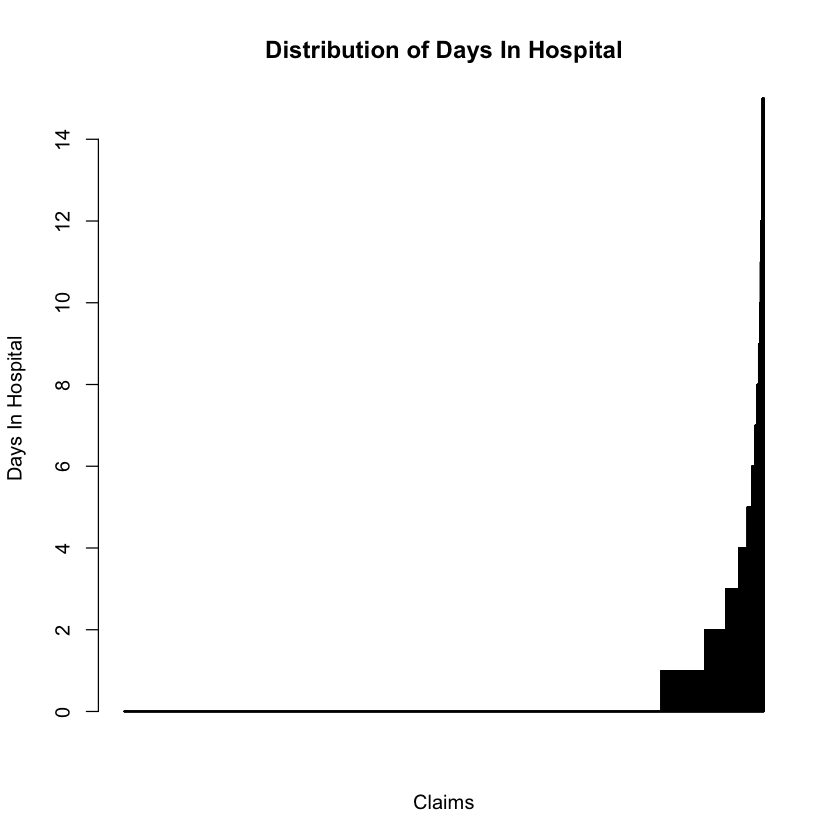

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   1.000   2.000   2.833   3.000  15.000 

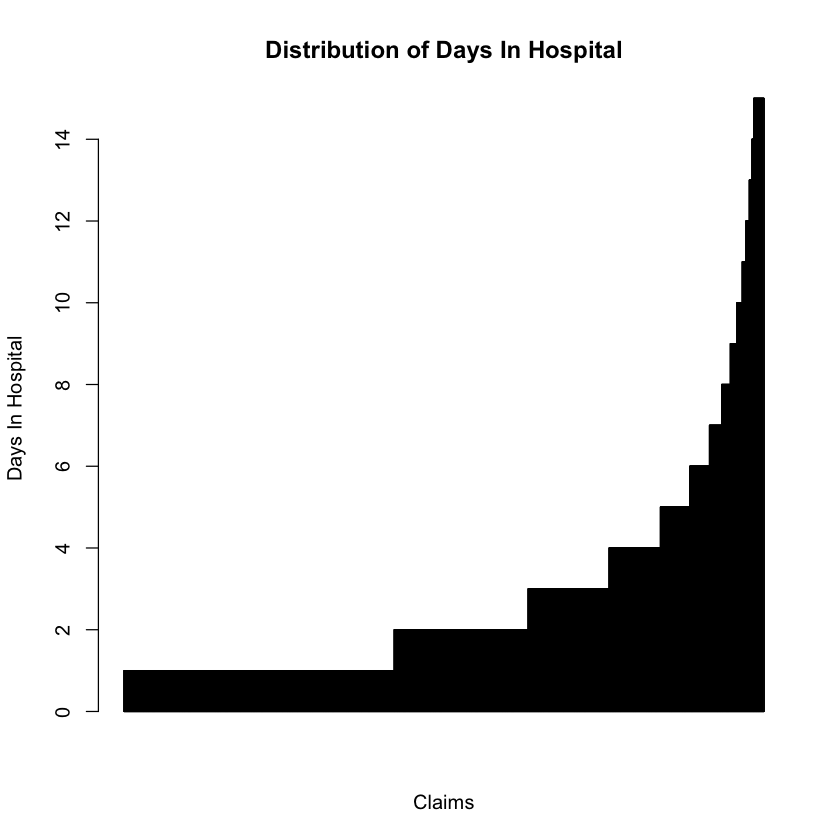

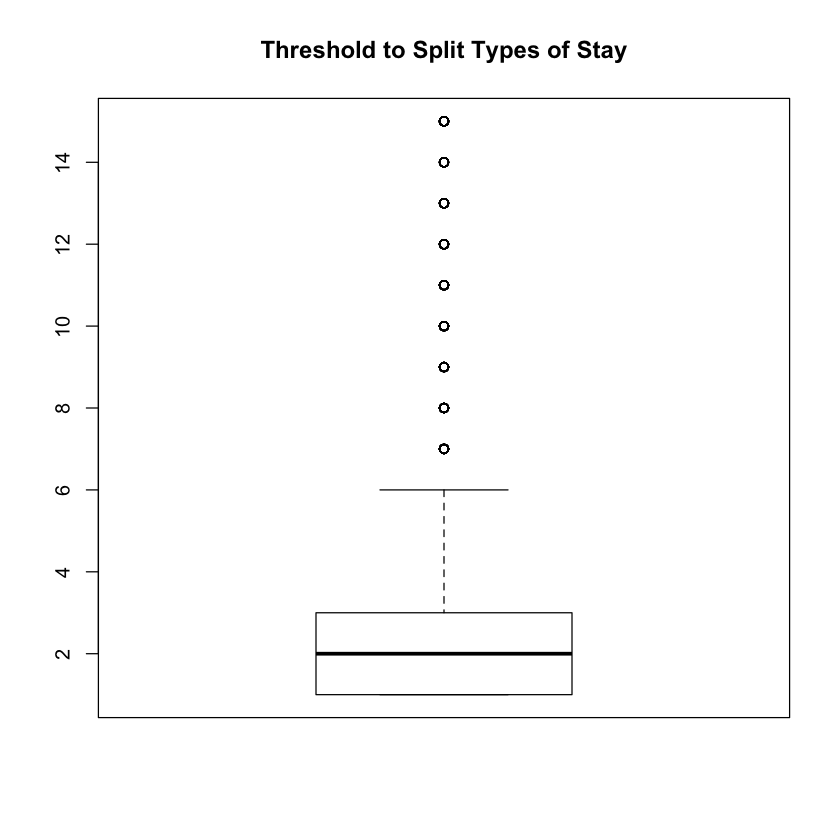

    MemberID                       PlaceSvc      LengthOfStay    
 Min.   :   20072   Office             :77210   Min.   : 0.0000  
 1st Qu.:24220446   Independent Lab    :39676   1st Qu.: 0.0000  
 Median :49905982   Urgent Care        :20204   Median : 0.0000  
 Mean   :49747952   Inpatient Hospital :18160   Mean   : 0.1106  
 3rd Qu.:75787462   Outpatient Hospital: 8756   3rd Qu.: 0.0000  
 Max.   :99936299   Other              : 1548   Max.   :42.0000  
                    (Other)            : 2110                    
 PrimaryConditionGroup CharlsonIndex   AgeAtFirstClaim   Sex       
 MSC2a3  :27582        Min.   :0.000   Min.   : 0.00   F   :57713  
 ARTHSPIN:16784        1st Qu.:0.000   1st Qu.:60.00   M   :36699  
 METAB3  :16158        Median :1.500   Median :70.00   NA's:73252  
 NEUMENT : 8334        Mean   :1.132   Mean   :62.98               
 GIBLEED : 8287        3rd Qu.:1.500   3rd Qu.:70.00               
 MISCHRT : 7420        Max.   :5.000   Max.   :80.00            

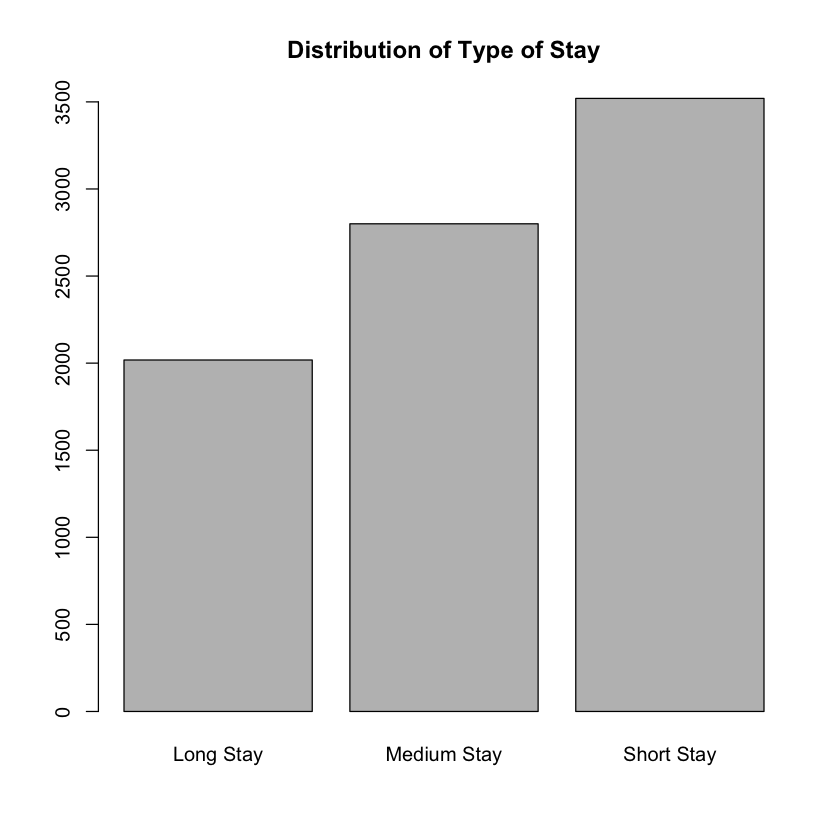

In [38]:
dihY3 <- read.csv(file="DaysInHospital_Y3.csv")
# if(!file.exists("all_clean.rds")) {
    # extract Y2
    claimsY2 <- claims[claims$Year == "Y2",]
    drugsY2 <- drugs[drugs$Year == "Y2",]
    labsY2 <- labs[labs$Year == "Y2",]
    membersY2 <- members
    
    # add number of claims
    n_claims <- table(claimsY2$MemberID)
    membersY2 <- merge(membersY2, data.frame(MemberID=names(n_claims),
      claims=as.numeric(n_claims)))
    
    # translate age WITH NA
    age <- gsub("(\\d+).*", "\\1", levels(membersY2$AgeAtFirstClaim))
    levels(membersY2$AgeAtFirstClaim) <- age
    membersY2$AgeAtFirstClaim <- as.numeric(as.character(membersY2$AgeAtFirstClaim))
    
    # DaysInHospital
    membersY2 <- merge(membersY2, dihY2)
    barplot(sort(membersY2$DaysInHospital), ylab="Days In Hospital",xlab="Claims", main="Distribution of Days In Hospital")
    membersY2 <- membersY2[membersY2$DaysInHospital>0,]
    barplot(sort(membersY2$DaysInHospital), ylab="Days In Hospital",xlab="Claims", main="Distribution of Days In Hospital")
    summary(membersY2$DaysInHospital)
    boxplot(membersY2$DaysInHospital, main="Threshold to Split Types of Stay")
    membersY2$InHospital[membersY2$DaysInHospital==1] <- "Short Stay"
    membersY2$InHospital[membersY2$DaysInHospital<=3&membersY2$DaysInHospital>=2] <- "Medium Stay"
    membersY2$InHospital[membersY2$DaysInHospital>3] <- "Long Stay"
    membersY2$InHospital <- as.factor(membersY2$InHospital)
    membersY2 <- subset(membersY2, select=c(MemberID, AgeAtFirstClaim, Sex, claims, InHospital))
    barplot(table(membersY2$InHospital), main="Distribution of Type of Stay")
#     summary(membersY2) # shows class inbalanced problem
    

    #Gender WITH NA
    membersY2$Sex[membersY2$Sex == ""] <- NA
    membersY2$Sex <- factor(membersY2$Sex)
    
    #DRUG CLAIM
    n_dclaims <- table(drugsY2$MemberID)
    membersY2 <- merge(membersY2, data.frame(MemberID=names(n_dclaims),
      dclaims=as.numeric(n_dclaims)))   


    #DRUG
    levels(drugsY2$DrugCount) <- c(1,2,3,4,5,6,7)
    drugsY2$DrugCount <- as.numeric(as.character(drugsY2$DrugCount))
    drugsY2$MemberID <- as.factor(drugsY2$MemberID)
    drugsY2 <- aggregate(DrugCount~MemberID, drugsY2, sum)
    membersY2 <- merge(membersY2,data.frame(MemberID = drugsY2$MemberID,DrugCount = as.numeric(drugsY2$DrugCount)))
    # summary(membersY2)

    #LAB
    levels(labsY2$LabCount) <- c(1,10,2,3,4,5,6,7,8,9)
    labsY2$LabCount <- as.numeric(as.character(labsY2$LabCount))
    labsY2$MemberID <- as.factor(labsY2$MemberID)
    labsY2 <- aggregate(LabCount~MemberID, labsY2, sum)
    membersY2 <- merge(membersY2,data.frame(MemberID = labsY2$MemberID,LabCount = as.numeric(labsY2$LabCount)))
    
    # translate Charlson Index
    levels(claimsY2$CharlsonIndex) <- c(0, 1.5, 3.5, 5)
    claimsY2$CharlsonIndex <- as.numeric(as.character(claimsY2$CharlsonIndex))

    #translate LOS
    levels(claimsY2$LengthOfStay) <- c(0, 1, 11, 2, 21, 112, 3, 4, 42, 5, 6)
    claimsY2$LengthOfStay <- as.numeric(as.character(claimsY2$LengthOfStay))
    
    claimsY2 <- data.frame(MemberID = claimsY2$MemberID, 
                           PlaceSvc = claimsY2$PlaceSvc,
                           LengthOfStay = claimsY2$LengthOfStay,
                           PrimaryConditionGroup = claimsY2$PrimaryConditionGroup, 
                           CharlsonIndex = claimsY2$CharlsonIndex)
    claimsY2 <- claimsY2[claimsY2$PrimaryConditionGroup!="",]
    claimsY2$PrimaryConditionGroup <- factor(claimsY2$PrimaryConditionGroup)
    claimsY2 <- claimsY2[claimsY2$PlaceSvc!="",]
    claimsY2$PlaceSvc <- factor(claimsY2$PlaceSvc)
#     summary(claimsY2)
#     summary(membersY2)
    allsetY2 <- merge(claimsY2, membersY2, by = "MemberID")
#     summary(allset)
#     save(allset, file="all_clean.rds")
# }

# load("all_clean.rds")
summary(allsetY2)

In [39]:
library(lattice)
library(ggplot2)
library(caret)
nodummyY2 <- subset(allsetY2, select=c(MemberID, InHospital))
yesdummyY2 <- allsetY2[ , ! colnames(allsetY2) %in% c("InHospital") ]
data_dummyY2 <- predict(dummyVars(~., yesdummyY2), yesdummyY2)
data_dummyY2 <- data.frame(data_dummyY2)
# summary(data_dummyY2)
dummy_onlyY2 <- data_dummyY2

weight <- matrix(c(rep(1/8,8),1,rep(1/45,45),1,1,1/2,1/2,1,1,1,1), 
   ncol = 62, 
   nrow = nrow(data_dummyY2), 
   byrow = TRUE)
temp <- scale(data_dummyY2[, -c(1)])*weight
data_dummyY2[, -c(1)] <- temp
scaledY2 <- data_dummyY2

# Problem: number of row will increase if merge
dummy_onlyY2$InHospital <- nodummyY2$InHospital
dummy_onlyY2 <- dummy_onlyY2[ , ! colnames(dummy_onlyY2) %in% c("MemberID") ]
scaledY2$InHospital <- nodummyY2$InHospital
scaledY2 <- scaledY2[ , ! colnames(scaledY2) %in% c("MemberID") ]
scaled_nonaY2 <- na.omit(scaledY2)

dummy_only_importantY2 <- subset(dummy_onlyY2, select = c( PrimaryConditionGroup.PRGNCY,
                                                       CharlsonIndex,
                                                       dclaims,
                                                       AgeAtFirstClaim,
                                                       LabCount,
                                                       claims,
                                                       DrugCount))
dummy_only_importantY2$InHospital <- dummy_onlyY2$InHospital
scaled_nona_importantY2 <- subset(scaled_nonaY2, select =c(PrimaryConditionGroup.PRGNCY,
                                                       CharlsonIndex,
                                                       dclaims,
                                                       AgeAtFirstClaim,
                                                       LabCount,
                                                       claims,
                                                       DrugCount))
scaled_nona_importantY2$InHospital <- scaled_nonaY2$InHospital
# summary(scaled_nona_important)
finalscaledY2 <- scaled_nona_importantY2
finaldummyY2 <- dummy_only_importantY2

In [40]:
finalscaledY2<-finalscaledY2[ , ! colnames(finalscaledY2) %in% c("InHospital") ]
summary(finalscaledY2)

 PrimaryConditionGroup.PRGNCY CharlsonIndex         dclaims        
 Min.   :-0.0032110           Min.   :-1.37227   Min.   :-2.35244  
 1st Qu.:-0.0032110           1st Qu.:-1.37227   1st Qu.:-0.52017  
 Median :-0.0032110           Median : 0.44583   Median : 0.39596  
 Mean   : 0.0008087           Mean   : 0.01059   Mean   : 0.05355  
 3rd Qu.:-0.0032110           3rd Qu.: 0.44583   3rd Qu.: 1.00672  
 Max.   : 0.1537926           Max.   : 4.68807   Max.   : 1.00672  
 AgeAtFirstClaim       LabCount             claims           DrugCount       
 Min.   :-3.53653   Min.   :-1.327651   Min.   :-3.11099   Min.   :-1.39894  
 1st Qu.:-0.16711   1st Qu.:-0.624356   1st Qu.:-0.76657   1st Qu.:-0.78350  
 Median : 0.39446   Median :-0.008974   Median : 0.79638   Median :-0.12071  
 Mean   : 0.05643   Mean   : 0.160832   Mean   : 0.04853   Mean   : 0.05889  
 3rd Qu.: 0.39446   3rd Qu.: 0.694320   3rd Qu.: 0.79638   3rd Qu.: 0.73144  
 Max.   : 0.95603   Max.   : 5.529469   Max.   : 0.79638

In [41]:
dtresult <- predict(fit,finalscaledY2)
summary(dtresult)

Long Stay Medium Stay  Short Stay 
      32297       23666       30786

In [42]:
options(warn=-1)
nbresult <- predict(nbmodel,finalscaledY2)$class
options(warn=0)
summary(nbresult)

Long Stay Medium Stay  Short Stay 
      40122        2253       44374

In [43]:
svmresult <- predict(svmmodel, finalscaledY2)
summary(svmresult)

Long Stay Medium Stay  Short Stay 
      38310       21341       27098

In [77]:
# library(ROCR)
# library(gplots)
# t <- as.numeric(train$InHospital == "Short Stay")
# pred1 <- prediction(predict(svmmodel,finalscaledY2), t)
# perf1 <- performance(pred1,"tpr","fpr")
# plot(perf1)

ERROR: Error in prediction(predict(svmmodel, finalscaledY2), t): Format of predictions is invalid.


In [83]:
prob <- predict(fit, finalscaledY2, type = "prob")

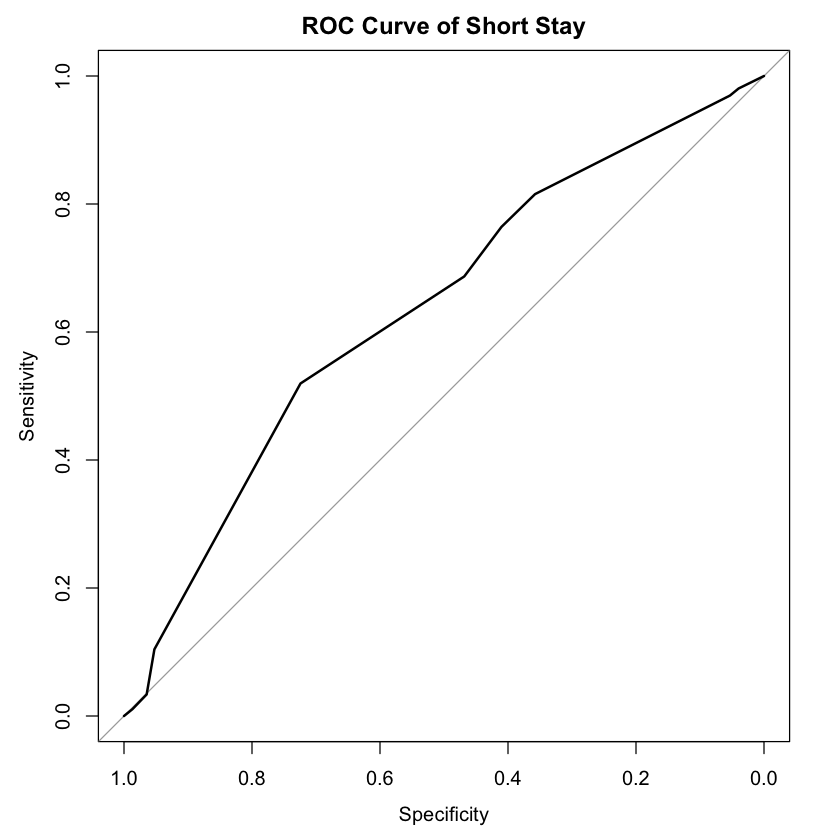

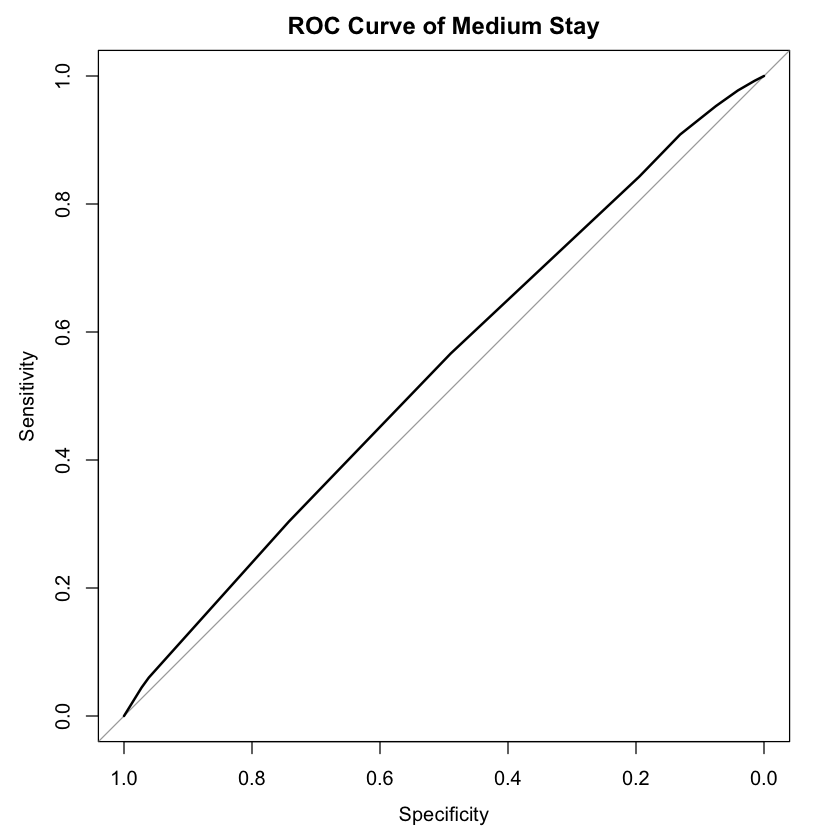

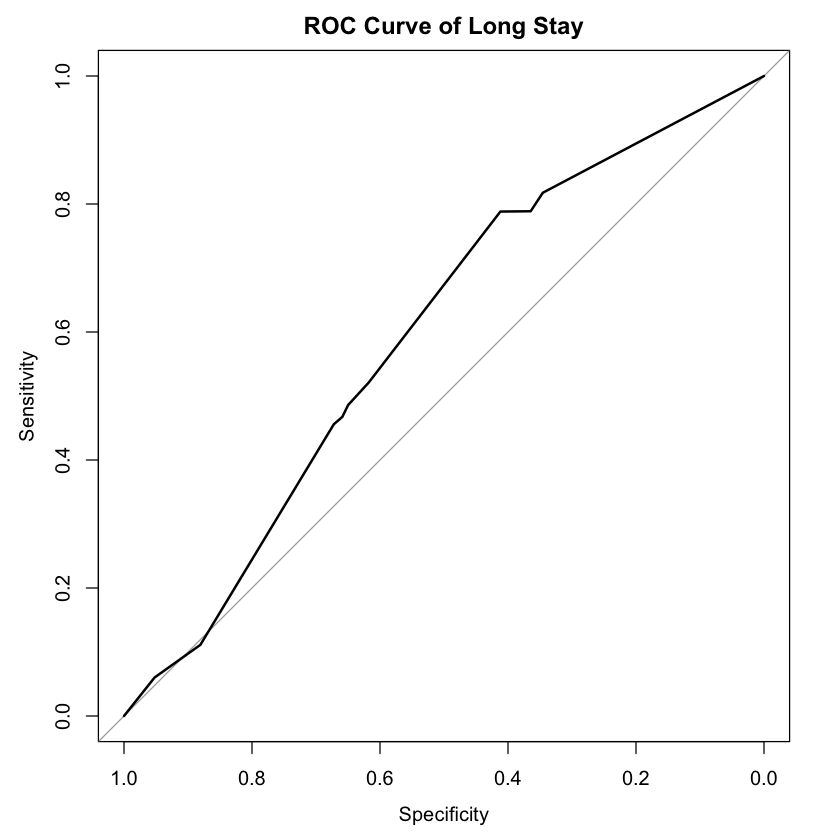

In [92]:
library("pROC")
# tail(prob)
sr <- roc(scaled_nonaY2$InHospital == "Short Stay", prob[,"Short Stay"])
plot(sr, main="ROC Curve of Short Stay")
mr <- roc(scaled_nonaY2$InHospital == "Medium Stay", prob[,"Medium Stay"])
plot(mr, main="ROC Curve of Medium Stay")
lr <- roc(scaled_nonaY2$InHospital == "Long Stay", prob[,"Long Stay"])
plot(lr, main="ROC Curve of Long Stay")

In [59]:
answer <- scaled_nonaY2$InHospital
# summary(answer)
nbgrade <- data.frame(nbresult,answer)
nbgrade$score <- nbgrade$nbresult==nbgrade$answer
summary(nbgrade$score)
nrow(nbgrade[nbgrade$score==TRUE,])/nrow(nbgrade)

   Mode   FALSE    TRUE 
logical   46666   40083 

[1] 0.4620572

In [60]:
answer <- scaled_nonaY2$InHospital
# summary(answer)
svmgrade <- data.frame(svmresult,answer)
svmgrade$score <- svmgrade$svmresult==svmgrade$answer
summary(svmgrade$score)
nrow(svmgrade[svmgrade$score==TRUE,])/nrow(svmgrade)

   Mode   FALSE    TRUE 
logical   46941   39808 

[1] 0.4588871

In [87]:
pred2 <- prediction(svmgrade$svmresult, svmgrade$answer)
perf2 <- performance(pred2,"tpr","fpr")
plot(perf2)

ERROR: Error in prediction(svmgrade$svmresult, svmgrade$answer): Format of predictions is invalid.
